# Comparison of cmip6, lmdz-or simulation, esa cci gf, and reanalysis relying on the climatologcal avergage over the period 1982-2014

## Load required libraries

In [1]:
import numpy as np      
import pandas as pd       
import netCDF4 as nc         
from netCDF4 import Dataset      
import matplotlib.pyplot as plt      
import xarray as xr      
import cartopy.crs as ccrs            
import cartopy         
import os           
from cartopy.feature import NaturalEarthFeature           
import cartopy.crs as ccrs       
import cartopy.feature as cf               
from cartopy.util import add_cyclic_point               
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter                  

## For parallelisation

In [2]:
from dask.distributed import Client
client = Client(n_workers=16, threads_per_worker=2, memory_limit='32GB')
client

/home/hchaabani/anaconda3/envs/first_part/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40763 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40763/status,
Dashboard: http://127.0.0.1:40763/status,Workers: 16
Total threads: 32,Total memory: 476.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39281,Workers: 16
Dashboard: http://127.0.0.1:40763/status,Total threads: 32
Started: Just now,Total memory: 476.84 GiB
Comm: tcp://127.0.0.1:40187,Total threads: 2
Dashboard: http://127.0.0.1:44259/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:38929,


## Set variables

In [3]:
wet_months_labels = ["JAN","FEB","MAR","APR","NOV","DEC"]
dry_months_labels = ["MAY","JUN","JUL","AUG","SEP","OCT"]
months_key = ['wet','dry']
months_labels = {'wet':wet_months_labels,'dry':dry_months_labels}
latlim = slice(30,34.5)
lonlim = slice(-10, -2)
period = slice('1982-01-01', '2014-12-31')

# Set input data
path_cmip6_raw_data = '/home/hchaabani/Data/pr/cmip6/raw_data'
path_cmip6 = '/home/hchaabani/Data/pr/cmip6/modified_data/monthly_values'
path_era5 = '/home/hchaabani/Data/pr/reanalysis/era5/modified_data/monthly_values'
path_era5_land ='/home/hchaabani/Data/pr/reanalysis/era5_land/modified_data/monthly_values'
                                                     
cmip6_labels = os.listdir(path_cmip6_raw_data)       
products_labels = ['era5_land','era5'] + cmip6_labels                

output_path_figures = '/home/hchaabani/Hamid/PHD-mountain-climate/First_Part/Results/figures/maps/v6/means/pr'

mon_days = {'wet':[31,28,31,30,30,31],'dry':[31,30,31,31,30,31]}
months = {'wet':[1,2,3,4,11,12],'dry':[5,6,7,8,9,10]}

dic_data = {prod:'data' for prod in products_labels}

leg_title = 'precipitation in mm'
max_leg = 4
min_leg = 0

y_titles = {'era5_land':'era5_land-10km','era5':'era5-25km',
           'BCC-CSM2-HR':'BCC-CSM2-HR','EC-Earth3P-HR':'EC-Earth3P-HR-25km',
            'IPSL-CM6A-ATM-ICO-HR':'IPSL-CM6A-ATM-ICO-HR-50km',
            'IPSL-CM6A-ATM-ICO-VHR':'IPSL-CM6A-ATM-ICO-VHR-25km',
            'IPSL-CM6A-ATM-HR':'IPSL-CM6A-ATM-HR',
            'CNRM-CM6-1-HR':'CNRM-CM6-1-HR-50km'}  
par = 'pr'         

## Importing and preparing data 

In [4]:
for prod in products_labels[2:]:
    dic_data[prod] = xr.open_dataset(path_cmip6 + '/pr_monthly_'+prod+'.nc').sel(time=period).load()

dic_data['era5'] = xr.open_dataset(path_era5 + '/pr_monthly_era5.nc').sel(time=period).load()
dic_data['era5_land'] = xr.open_dataset(path_era5_land + '/pr_monthly_era5_land.nc').sel(time=period).load()

In [5]:
#for prod in products_labels[0:2]:
#    dic_data[prod] = dic_data[prod].rename({'longitude':'lon','latitude':'lat','tp':'pr'})

In [6]:
for prod in products_labels[2:0]:
    dic_data[prod] = dic_data[prod].sel(lat=latlim, lon=lonlim)
latlim = slice(45,15)  
for prod in products_labels[0:2]:
    dic_data[prod] = dic_data[prod].sel(lat=latlim, lon=lonlim)

## The monthly climatological averages

In [7]:
# We define a dictionnary that will contain the five datasets of monthly averages of all above-mentioned variables 
monthly_values_basic_mean = {prod:'a' for prod in products_labels}

In [8]:
# We compute the averages off all variables for all datasets 
for prod in products_labels:   
    monthly_values_basic_mean[prod] = dic_data[prod].groupby('time.month').mean(dim='time')

## Plots

<div class="alert alert-block alert-success"; background-color:red> We define the formatting function of the figures </div> 

In [9]:
# This auxiliary function will help us in the formatting of the figures
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

<div class="alert alert-block alert-success"; background-color:red> We personalize the colorbar </div> 

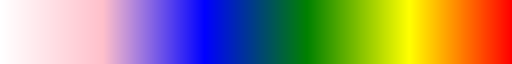

In [10]:
import matplotlib as mpl
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c0='white'
c1='pink' 
c2='blue' 
c3='green' 
c4='yellow' 
c5='red' 

n=250

colors0 = []
colors1 = []
colors2 = []
colors3 = []
colors4 = []
for x in range(n+1):
    colors0.append(colorFader(c0,c1,x/n))
    colors1.append(colorFader(c1,c2,x/n))
    colors2.append(colorFader(c2,c3,x/n))
    colors3.append(colorFader(c3,c4,x/n))
    colors4.append(colorFader(c4,c5,x/n))

colors = colors0 + colors1 + colors2 + colors3 + colors4

cmap_init = mpl.colors.ListedColormap(colors)
cmap_init

/tmp/ipykernel_25431/944707325.py:69: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = fig.colorbar(cs, cax=cbar_ax, cmap=cmap_init , label=leg_title, ticks=[val for val in range(min_leg,max_leg,1)], orientation='horizontal')
/tmp/ipykernel_25431/944707325.py:69: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = fig.colorbar(cs, cax=cbar_ax, cmap=cmap_init , label=leg_title, ticks=[val for val in range(min_leg,max_leg,1)], orientation='horizontal')
/home/hchaabani/anaconda3/envs/first_part/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an e

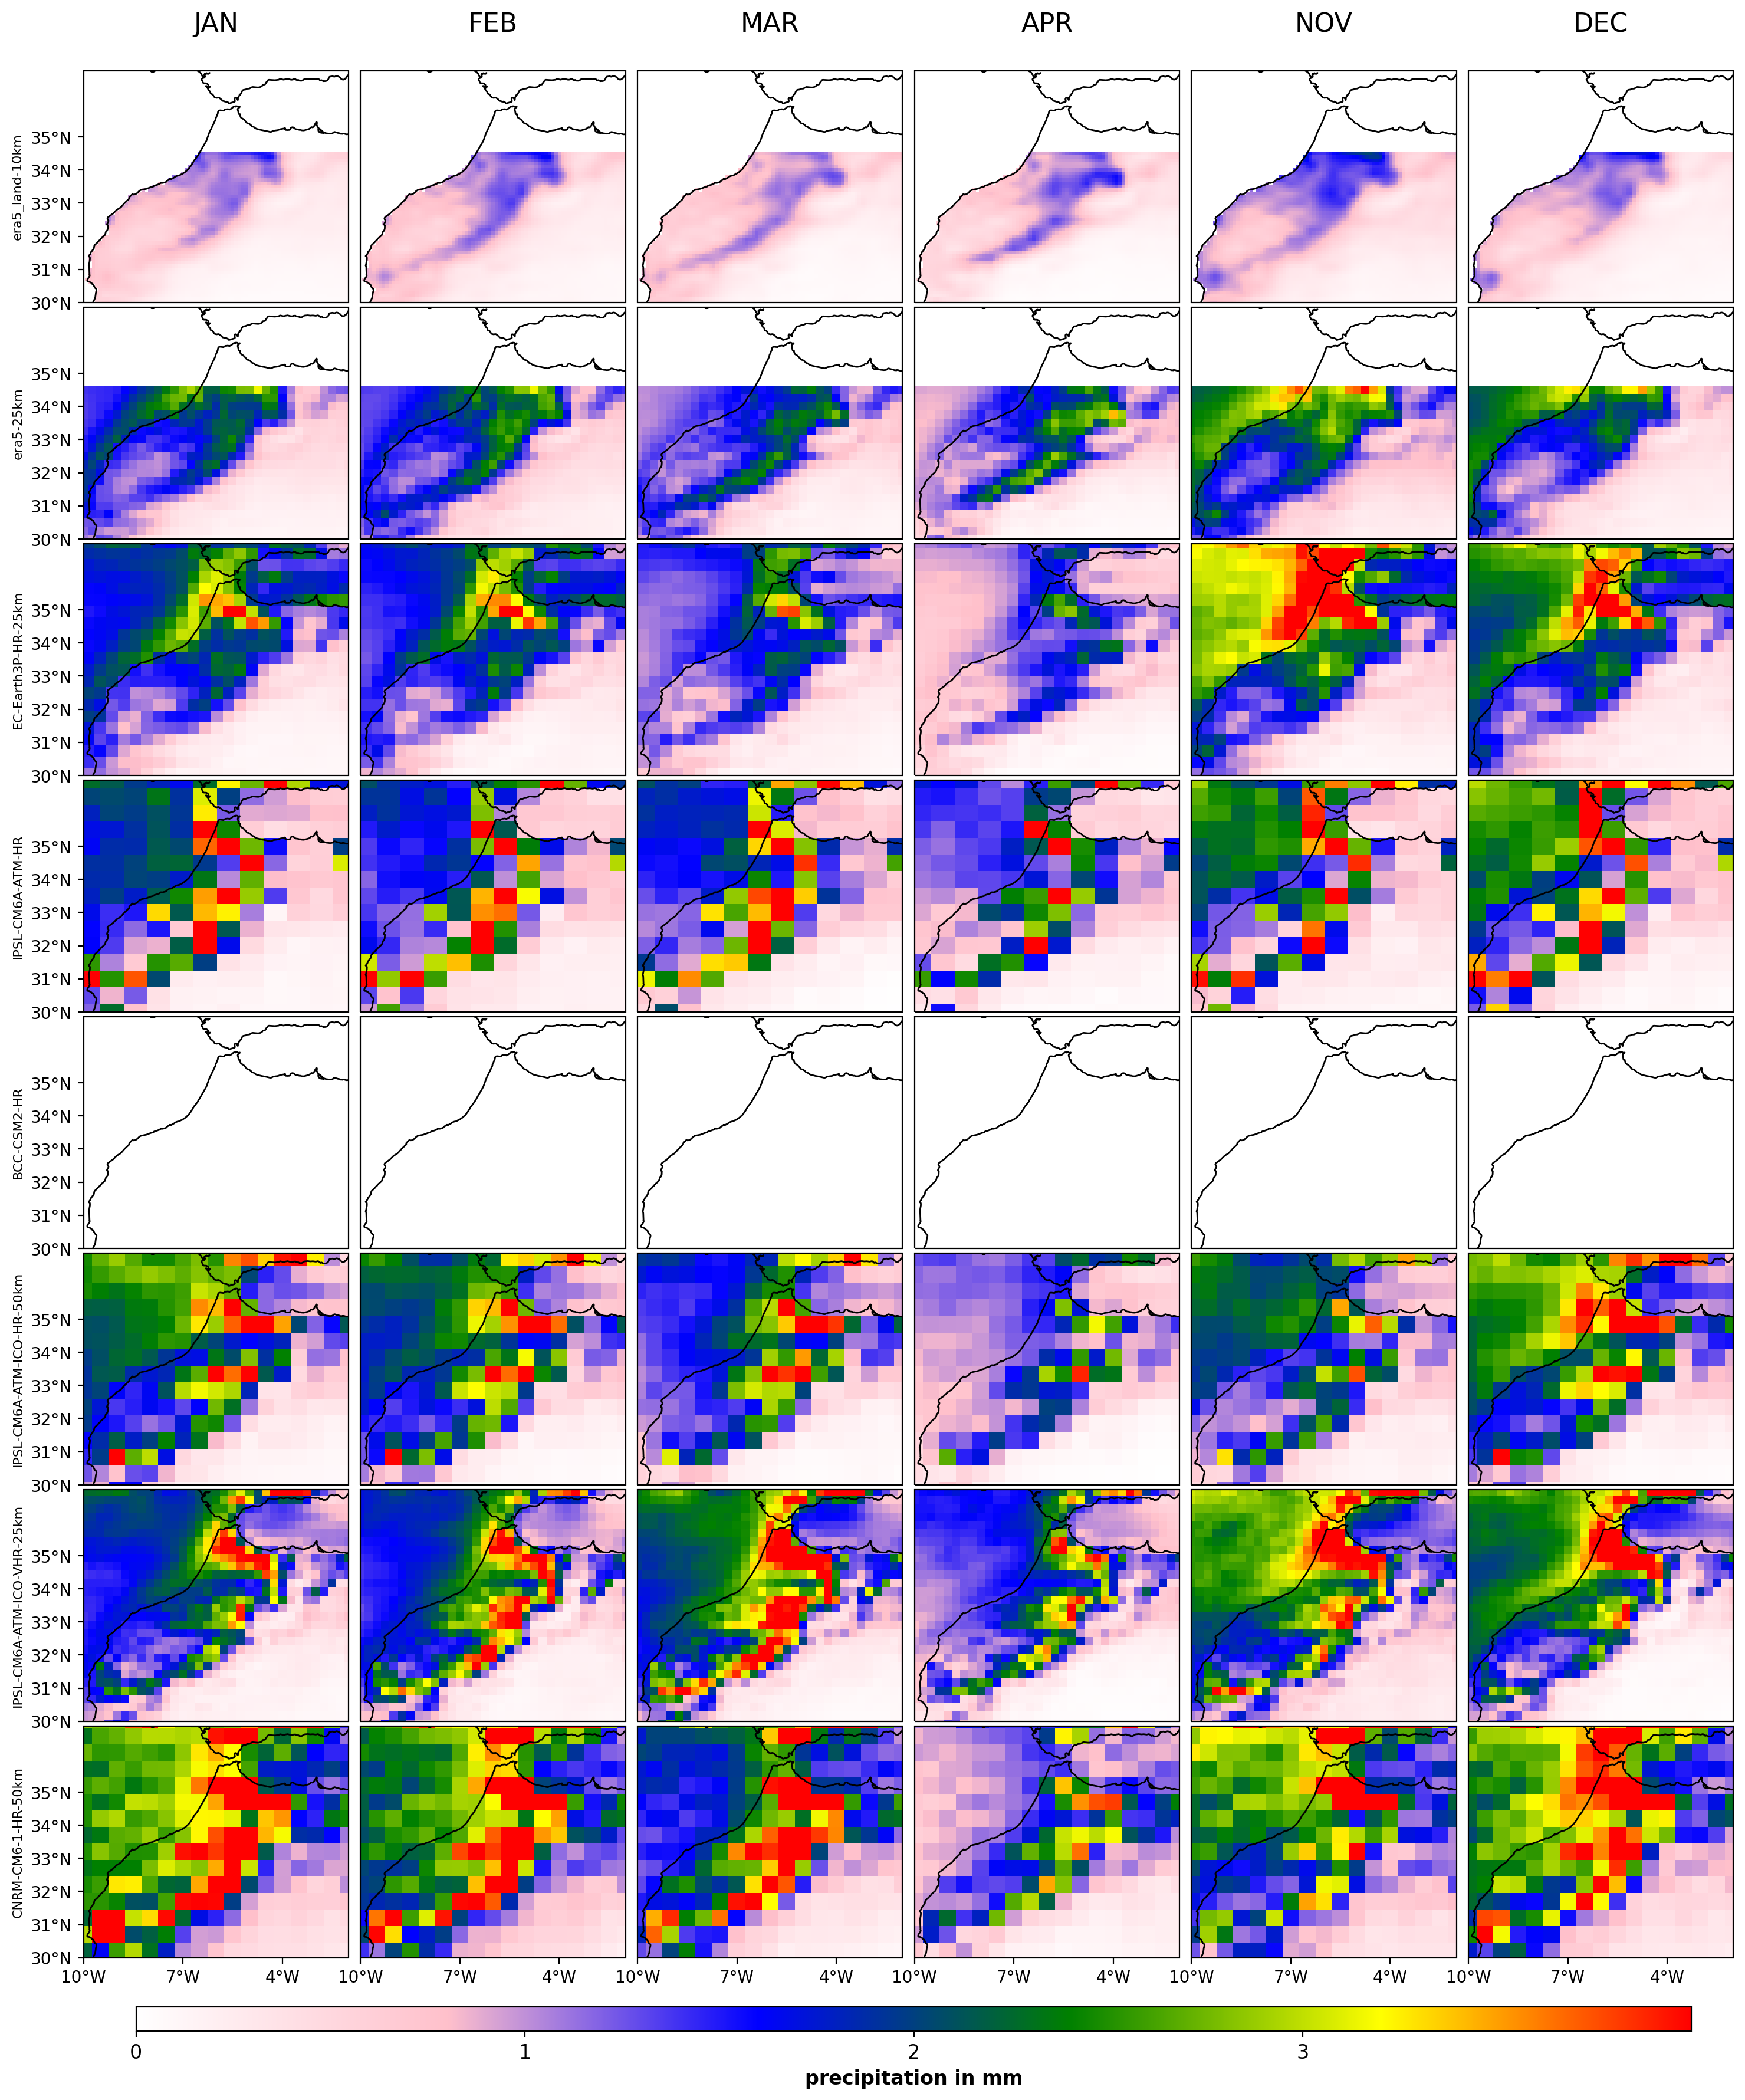

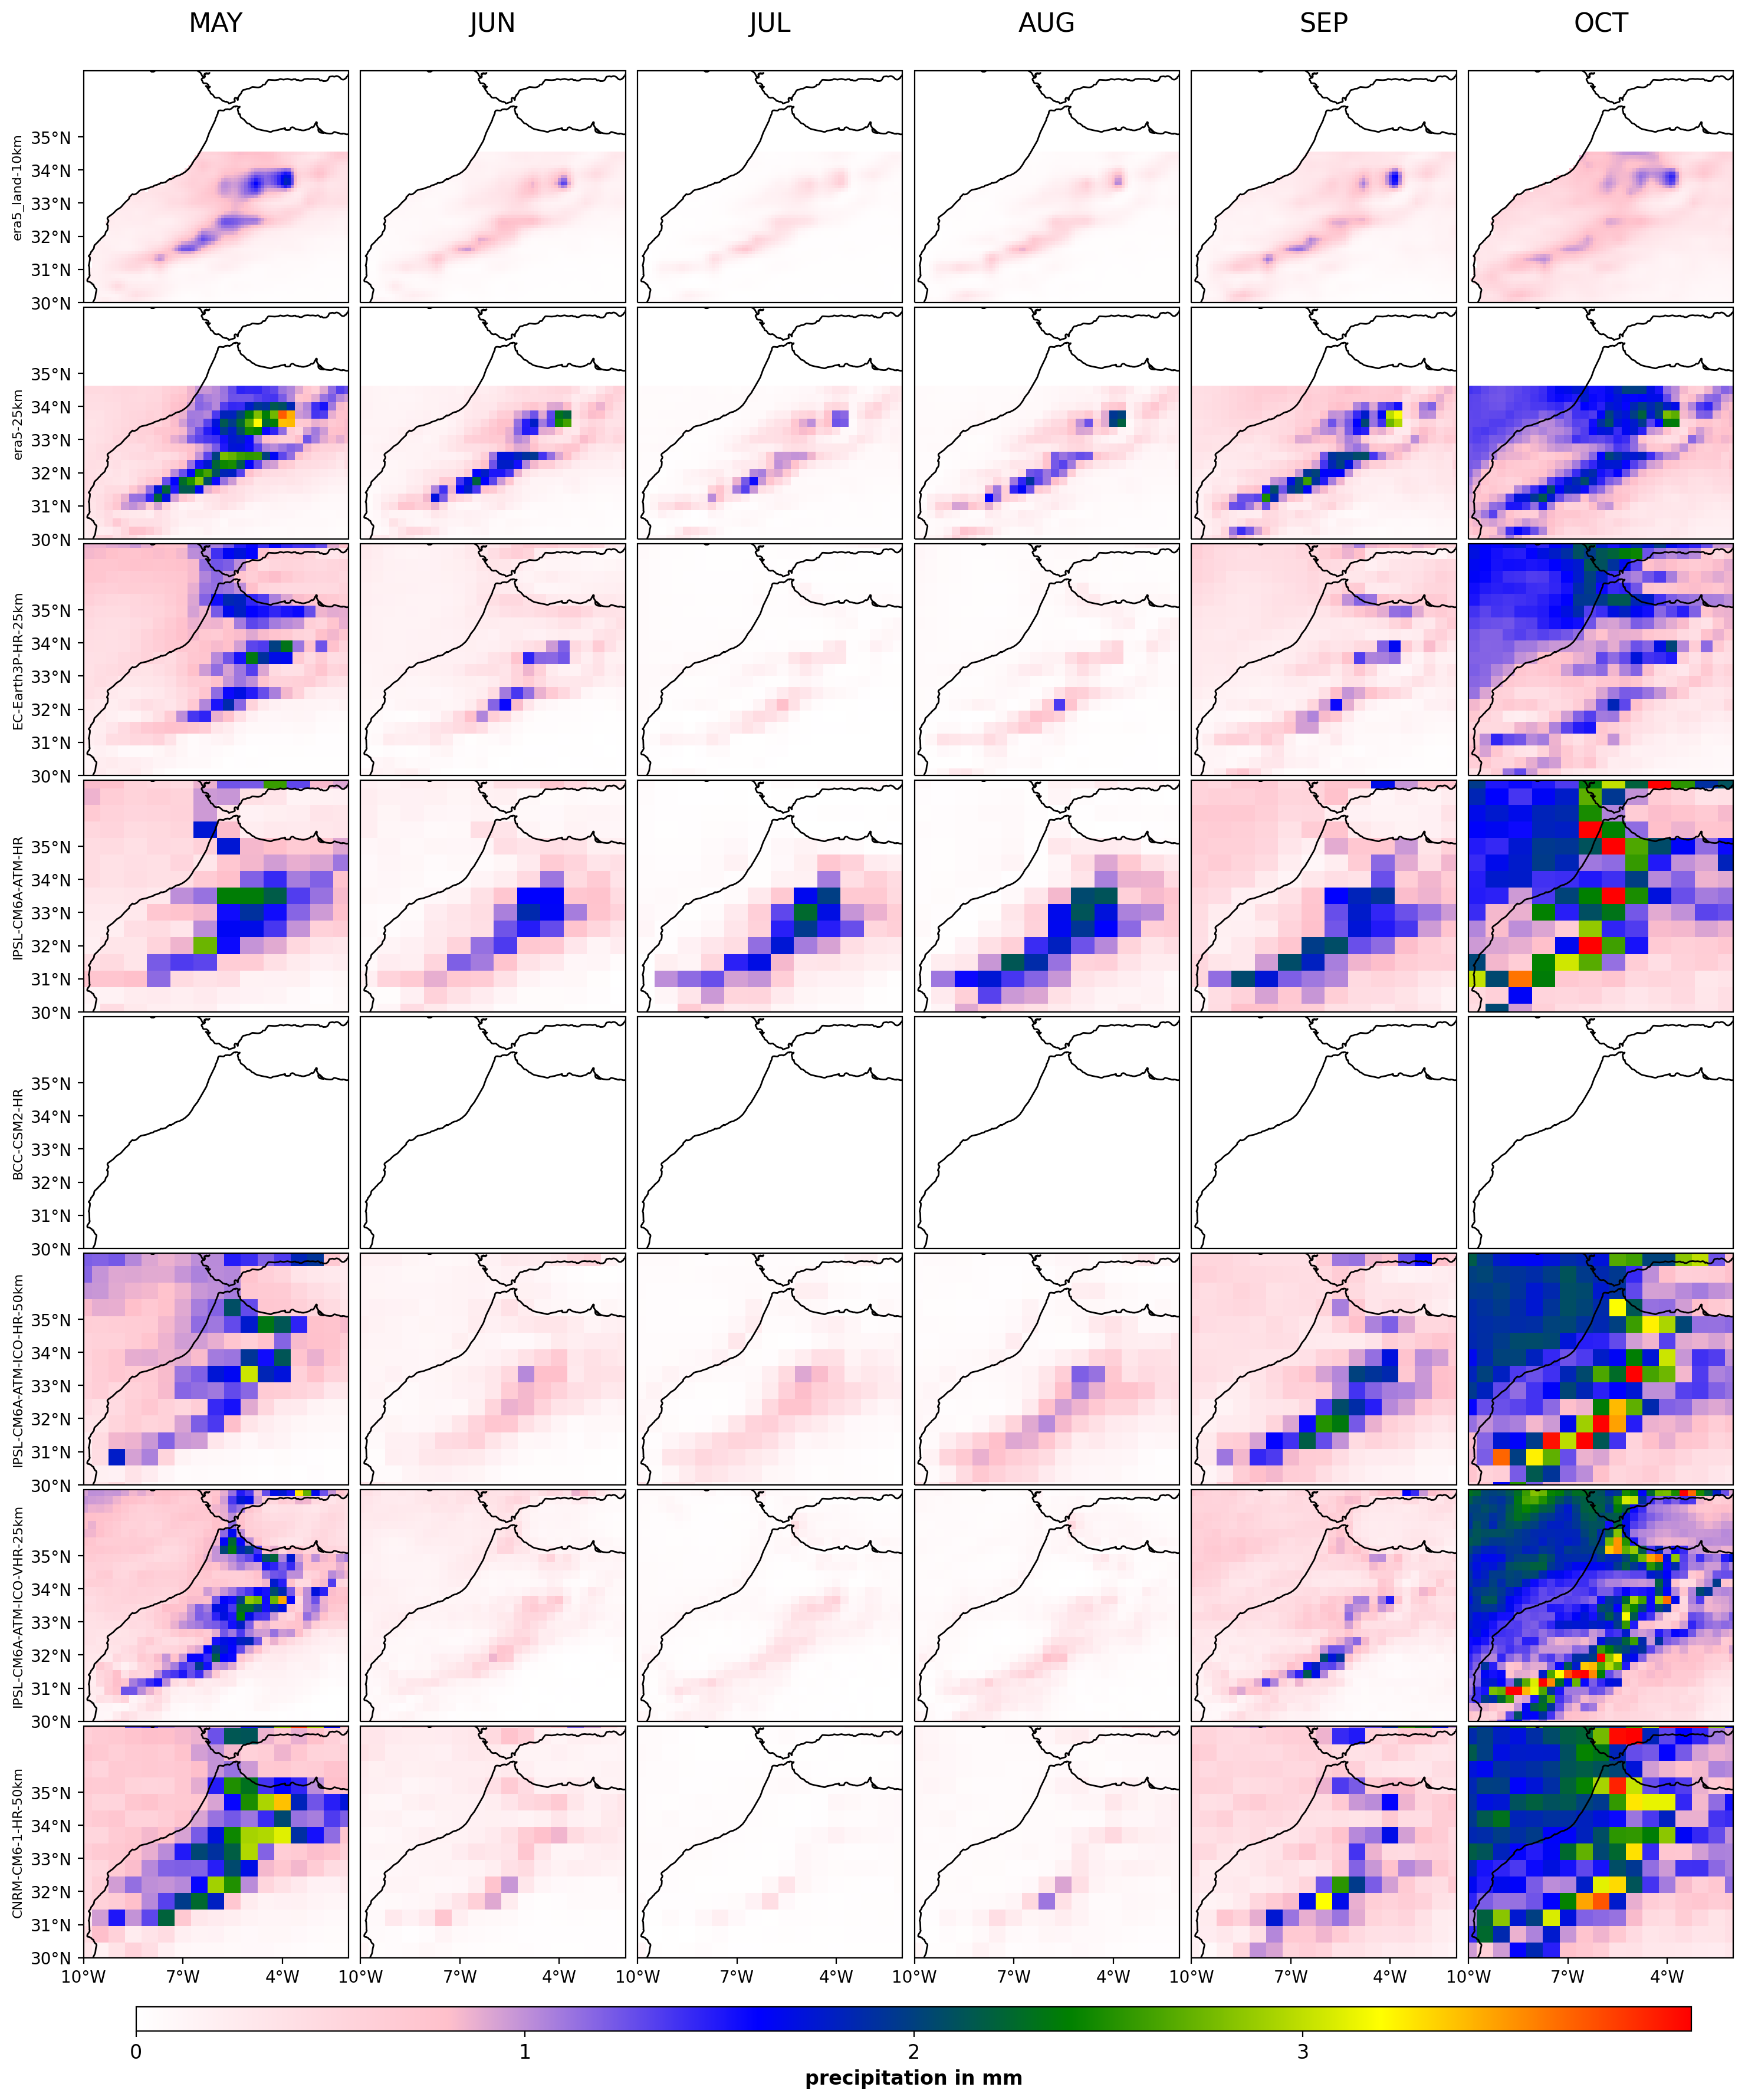

In [27]:
statios_colors = ["darkgreen","orange", "lemonchiffon","khaki", "palegoldenrod","darkblue"]
# We define stations labels and coordinates to be ploted on the map
lats = np.array([33.5,32.67,31.53,31.50,31.56,31.20,36])
lons = np.array([-5.16,-4.74,-6.30,-6.45,-6.29,-7.86, -9.8])
names = [" IFR", " MID", "", "TIC,MGN,TIZ", "", " OUK"] #, 'spatial_mean_value']  

for ikey_mon, key_mon in enumerate(['wet','dry']):
    # Define the figure and each axis for the 3 rows and 3 columns
    fig, axs = plt.subplots(nrows=8,ncols=6,
                            subplot_kw={'projection': ccrs.PlateCarree()}, dpi=200) #   figsize=(11,8.5)
    # Formatting figure 
    plt.subplots_adjust(wspace=0.04,hspace=0.02)
    set_size(14,16)      
    # Axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array as follow 
    axs=axs.flatten()

    i_ax=0 
    for ipord,prod in enumerate(products_labels):
        for imon,mon in enumerate(months[key_mon]):
            # Select the data of month mon and of produc
            data = monthly_values_basic_mean[prod].loc[{'month':mon}][par]
            
            # Plot climatological mean 
            cs = data.plot(ax=axs[i_ax], cmap=cmap_init , add_colorbar=False, vmin=min_leg, 
                           vmax=max_leg, add_labels=False)
            
            # axs[i_ax].add_feature(cf.NaturalEarthFeature('physical', '50m', edgecolor='face',
                                                        # facecolor='cyan'))
            axs[i_ax].set_extent([-10, -2, 30, 37])                        
    
            # Pointing the stations on one of the boxplots
            """  
            axs[i_ax].scatter(lons, lats, 20, color='black', marker=".", edgecolor='black')
            for j in range(len(names)):
                axs[i_ax].text(lons[j], lats[j], names[j], va="top", family="monospace", weight="bold", 
                                   fontsize=10, color='black')
            """
            
            
            # Draw the coastines for each subplot
            axs[i_ax].coastlines()
                                                                                            
            i_ax=i_ax+1
                
    k=0     
    for i_ax in range(0,47,6):      
        axs[i_ax].set_ylabel(y_titles[products_labels[k]],  fontsize=8)
        k=k+1
    
    for i_ax in range(6):
        axs[i_ax].set_title(months_labels[key_mon][i_ax]+'\n',  fontsize=16)
    
    # Longitude labels
    for i in range(42,48):  
        axs[i].set_xticks(np.arange(-10,-3,3), crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    for i in range(0,47,6):
        axs[i].set_yticks(np.arange(30,36,1), crs=ccrs.PlateCarree())
        lat_formatter = LatitudeFormatter()     
        axs[i].yaxis.set_major_formatter(lat_formatter) 
       
    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.15, 0.08, 0.73, 0.01])

    # Draw the colorbar     
    cb = fig.colorbar(cs, cax=cbar_ax, cmap=cmap_init , label=leg_title, ticks=[val for val in range(min_leg,max_leg,1)], orientation='horizontal') 
    cb.set_label(label=leg_title, weight='bold',size='large')
    cb.ax.tick_params(labelsize='large')         
    
    # Store figures  
    #plt.savefig(output_path_figures+'/'+par+'_'+key_mon+'_months_monthly_averages_threshold_snc_'+threshold+'.pdf')         
    #plt.savefig(output_path_figures+'/'+par+'_'+key_mon+'_months_monthly_averages_threshold_snc_'+threshold+'.png')         